SETUP & LOAD DATA

In [ ]:
import pandas as pd
import re
from collections import defaultdict

In [11]:
# Load dictionaries
teencode_df = pd.read_csv("/Users/copy/Downloads/TDTU/Labeling/thuvien/teencode.csv")
noise_df = pd.read_csv("/Users/copy/Downloads/TDTU/Labeling/thuvien/noise.csv")
english_df = pd.read_csv("/Users/copy/Downloads/TDTU/Labeling/thuvien/english.csv")
hanviet_df = pd.read_csv("/Users/copy/Downloads/TDTU/Labeling/thuvien/hanviet_dictionary.csv")
ten_rieng_df = pd.read_csv("/Users/copy/Downloads/TDTU/Labeling/thuvien/ten_rieng.csv")
phien_am_df = pd.read_csv("/Users/copy/Downloads/TDTU/Labeling/thuvien/phien_am.csv")


STEP 1 — TEXT NORMALIZATION
#Chuẩn hóa lyrics sử dụng "teencode.csv" và xóa noise sử dụng "noise.csv"

In [12]:
import pandas as pd
import re
import unicodedata

mapping = dict(zip(teencode_df["teen_code"], teencode_df["standard"]))

# dài → ngắn
keys = sorted(mapping.keys(), key=len, reverse=True)

pattern = re.compile(
    r'(?<!\w)(' + '|'.join(map(re.escape, keys)) + r')(?!\w)',
    flags=re.UNICODE
)

CONFUSABLE_MAP = {
    "Σ": "c",
    "Ɓ": "B",
    "Ɲ": "N",
    "Ɛ": "E",
    "Ɗ": "D",
    "Ŋ": "N",
    "Ļ": "L",
    "Ĭ": "I",
    "Ƭ": "T",
    "Ѵ": "V",
}

def normalize_confusable(text):
    for k, v in CONFUSABLE_MAP.items():
        text = text.replace(k, v)
    return text

def normalize_repeated_chars(text):
    return re.sub(r'(.)\1{2,}', r'\1', text)

def normalize_lyrics(text):
    if not isinstance(text, str):
        return text

    # 0. Unicode normalize (rất nên có)
    text = unicodedata.normalize("NFKC", text)

    # 1. confusable
    text = normalize_confusable(text)

    # 2. remove kéo dài
    text = normalize_repeated_chars(text)

    # 3. xoá noise
    text = re.sub(r"\.{2,}", " ", text)
    text = re.sub(r"[:()\-\u2013\u2014]", " ", text)
    text = re.sub(r",{2,}", " ", text)

    # 4. chuẩn hoá teencode
    text = pattern.sub(lambda m: mapping[m.group(0)], text)

    # 5. chuẩn hoá khoảng trắng
    text = re.sub(r"\s+", " ", text).strip()

    return text

df = pd.read_csv("/Users/copy/Downloads/TDTU/Labeling/final_dataset_cleaned_v3.csv")

df["lyrics"] = df["lyrics"].apply(normalize_lyrics)

df.to_csv("/Users/copy/Downloads/TDTU/Labeling/Calculate_Analysis/final_dataset_step1_teencode.csv", index=False)


Xóa noise, kết hợp noise.csv

In [15]:
import re
import pandas as pd

# INPUT: output step 1
df = pd.read_csv(
    "/Users/copy/Downloads/TDTU/Labeling/Calculate_Analysis/final_dataset_step1_teencode.csv"
)

# noise_df đã load sẵn
noise_list = (
    noise_df["noise"]
    .dropna()
    .astype(str)
    .str.strip()
    .unique()
    .tolist()
)

# =========================
# PHÂN LOẠI NOISE
# =========================
word_noise = []
phrase_noise = []

for n in noise_list:
    if len(n.split()) == 1 and len(n) <= 15:
        word_noise.append(n.lower())
    else:
        phrase_noise.append(n)

# =========================
# REGEX CHO WORD NOISE
# =========================
word_noise = sorted(word_noise, key=len, reverse=True)

word_pattern = re.compile(
    r'(?<!\w)(' + '|'.join(map(re.escape, word_noise)) + r')(?!\w)',
    flags=re.UNICODE | re.IGNORECASE
)

def clean_noise(text):
    if not isinstance(text, str):
        return text

    # 1️⃣ xoá phrase / sentence noise (substring)
    for p in phrase_noise:
        text = text.replace(p, " ")

    # 2️⃣ xoá word noise
    text = word_pattern.sub(" ", text)

    # 3️⃣ chuẩn hoá khoảng trắng
    text = re.sub(r"\s+", " ", text).strip()

    return text

df["lyrics"] = df["lyrics"].apply(clean_noise)

df.to_csv(
    "/Users/copy/Downloads/TDTU/Labeling/Calculate_Analysis/final_dataset_step2_noise.csv",
    index=False
)


Step 3 - Labeling theo phien_am => ten_rieng => han_viet => english =>

In [ ]:
import pandas as pd
import re
from typing import List, Tuple, Set, Dict
import ahocorasick
import time
from collections import defaultdict

# =========================
# 0. SETUP ENGLISH DICTIONARY
# =========================
def load_english_dict() -> Set[str]:
    """Load English dictionary from NLTK or fallback to basic set"""
    try:
        import nltk
        try:
            from nltk.corpus import words
            english_words = set(word.lower() for word in words.words())
            print(f"✅ Loaded {len(english_words):,} English words from NLTK")
            return english_words
        except LookupError:
            print("📥 Downloading NLTK words corpus (one-time setup)...")
            nltk.download('words', quiet=True)
            from nltk.corpus import words
            english_words = set(word.lower() for word in words.words())
            print(f"✅ Downloaded and loaded {len(english_words):,} English words")
            return english_words
    except Exception as e:
        print(f"⚠️  Could not load NLTK: {e}")
        print("ℹ️  Using basic English detection (regex only)")
        return set()

ENGLISH_DICT = load_english_dict()

# =========================
# 1. LOAD ALL DATA
# =========================
print("\n📂 Loading data...")

df = pd.read_csv(
    "/Users/copy/Downloads/TDTU/Labeling/Calculate_Analysis/final_dataset_step2_noise.csv"
)

# Load dictionaries
teencode_df = pd.read_csv("/Users/copy/Downloads/TDTU/Labeling/thuvien/teencode.csv")
noise_df = pd.read_csv("/Users/copy/Downloads/TDTU/Labeling/thuvien/noise.csv")
english_df = pd.read_csv("/Users/copy/Downloads/TDTU/Labeling/thuvien/english.csv")
hanviet_df = pd.read_csv("/Users/copy/Downloads/TDTU/Labeling/thuvien/hanviet_dictionary.csv")
ten_rieng_df = pd.read_csv("/Users/copy/Downloads/TDTU/Labeling/thuvien/ten_rieng.csv")
phien_am_df = pd.read_csv("/Users/copy/Downloads/TDTU/Labeling/thuvien/phien_am.csv")

print(f"✅ Loaded {len(df):,} lyrics rows")

# =========================
# 2. BUILD PHRASE DICTIONARIES
# =========================
print("\n🔨 Building phrase dictionaries with conflict detection...")

# Track conflicts: word -> list of labels
PHRASE_CONFLICTS: Dict[str, List[str]] = defaultdict(list)

# Lowercase dictionary (for matching)
PHRASE_LABEL_LOWER = {}

# Case-sensitive dictionary (for proper nouns)
PROPER_NOUN_EXACT = set()

# 1️⃣ PHIÊN ÂM – ƯU TIÊN CAO NHẤT
phien_am_count = 0
for col in phien_am_df.columns:
    clean_col = col.strip().replace(' ', '_').upper()
    label = f"FOREIGN_{clean_col}"

    values = phien_am_df[col].dropna().astype(str).str.strip()
    col_count = 0

    for v in values:
        v_lower = v.lower()
        if v_lower and v_lower != 'nan':
            # Track conflicts
            if v_lower in PHRASE_LABEL_LOWER:
                PHRASE_CONFLICTS[v_lower].append(PHRASE_LABEL_LOWER[v_lower])
                PHRASE_CONFLICTS[v_lower].append(label)
            else:
                PHRASE_CONFLICTS[v_lower].append(label)

            PHRASE_LABEL_LOWER[v_lower] = label
            col_count += 1
            phien_am_count += 1

    if col_count > 0:
        print(f"    • {clean_col:20s}: {col_count:,} phrases")

print(f"  → Total phiên âm: {phien_am_count:,}")

# 2️⃣ TÊN RIÊNG - CASE SENSITIVE!
values = ten_rieng_df.iloc[:, 0].dropna().astype(str).str.strip()
ten_rieng_count = 0

for v in values:
    if v and v != 'nan':
        # Store exact case for matching
        PROPER_NOUN_EXACT.add(v)

        # Also track in lowercase for conflict detection
        v_lower = v.lower()
        if v_lower in PHRASE_LABEL_LOWER:
            PHRASE_CONFLICTS[v_lower].append(PHRASE_LABEL_LOWER[v_lower])
            PHRASE_CONFLICTS[v_lower].append("PROPER_NOUN")
        else:
            PHRASE_CONFLICTS[v_lower].append("PROPER_NOUN")

        ten_rieng_count += 1

print(f"  → Total tên riêng: {ten_rieng_count:,}")

# 3️⃣ ENGLISH PHRASE
values = english_df.iloc[:, 0].dropna().astype(str).str.lower().str.strip()
english_count = 0

for v in values:
    if v and v != 'nan':
        if v in PHRASE_LABEL_LOWER:
            PHRASE_CONFLICTS[v].append(PHRASE_LABEL_LOWER[v])
            PHRASE_CONFLICTS[v].append("ENGLISH")
        else:
            PHRASE_CONFLICTS[v].append("ENGLISH")

        PHRASE_LABEL_LOWER[v] = "ENGLISH"
        english_count += 1

print(f"  → Total English phrases: {english_count:,}")
print(f"✅ Total phrases: {len(PHRASE_LABEL_LOWER):,}")

# =========================
# 3. DETECT AND EXPORT CONFLICTS
# =========================
print("\n🔍 Detecting conflicts...")

conflicts = {word: list(set(labels)) for word, labels in PHRASE_CONFLICTS.items() if len(set(labels)) > 1}

if conflicts:
    print(f"⚠️  Found {len(conflicts):,} words with multiple labels!")

    # Create conflict report
    conflict_data = []
    for word, labels in sorted(conflicts.items()):
        conflict_data.append({
            'word': word,
            'labels': ' | '.join(sorted(labels)),
            'count': len(labels)
        })

    conflict_df = pd.DataFrame(conflict_data)
    conflict_path = "/Users/copy/Downloads/TDTU/Labeling/Calculate_Analysis/label_conflicts.csv"
    conflict_df.to_csv(conflict_path, index=False)

    print(f"📄 Conflict report saved to: {conflict_path}")
    print(f"\n🔍 Sample conflicts:")
    for i, row in conflict_df.head(10).iterrows():
        print(f"  '{row['word']}' → {row['labels']}")

    if len(conflicts) > 10:
        print(f"  ... and {len(conflicts) - 10} more conflicts")
else:
    print("✅ No conflicts found!")

# =========================
# 4. WORD SETS
# =========================
print("\n🔨 Building word sets...")

HANVIET_SET = set(hanviet_df.iloc[:, 0].dropna().astype(str).str.lower())
print(f"✅ Loaded {len(HANVIET_SET):,} Hán-Việt words")

ENGLISH_PATTERN = re.compile(r"^[a-z]+$", re.IGNORECASE)

# =========================
# 5. LABEL FUNCTIONS
# =========================

def word_label(token: str) -> str:
    """Label a single word token"""
    t_lower = token.lower()

    # Check if it's pure English (a-z only)
    if ENGLISH_PATTERN.match(t_lower):
        if ENGLISH_DICT and t_lower in ENGLISH_DICT:
            return "ENGLISH"
        if t_lower in HANVIET_SET:
            return "HANVIET"
        return "ENGLISH"

    if t_lower in HANVIET_SET:
        return "HANVIET"

    return "VI"

def label_lyrics(text: str) -> List[Tuple[str, str]]:
    """
    Label lyrics with phrase and word-level labels
    - Proper nouns: case-sensitive matching
    - Other phrases: case-insensitive
    """
    if not text or pd.isna(text):
        return []

    words = text.split()
    if not words:
        return []

    words_lower = [w.lower() for w in words]
    matched = [False] * len(words)
    matches = []

    # Try to find multi-word phrases
    for i in range(len(words)):
        if matched[i]:
            continue

        # Try from longest to shortest phrase (max 10 words)
        for length in range(min(10, len(words) - i), 0, -1):
            # 1. Check PROPER NOUN (case-sensitive)
            phrase_exact = ' '.join(words[i:i + length])
            if phrase_exact in PROPER_NOUN_EXACT:
                matches.append((i, length, phrase_exact, "PROPER_NOUN"))
                for j in range(i, i + length):
                    matched[j] = True
                break

            # 2. Check other phrases (case-insensitive)
            phrase_lower = ' '.join(words_lower[i:i + length])
            if phrase_lower in PHRASE_LABEL_LOWER:
                label = PHRASE_LABEL_LOWER[phrase_lower]
                matches.append((i, length, phrase_lower, label))
                for j in range(i, i + length):
                    matched[j] = True
                break

    # Build output
    output = []
    match_dict = {m[0]: (m[1], m[2], m[3]) for m in matches}

    i = 0
    while i < len(words):
        if i in match_dict:
            length, phrase, label = match_dict[i]
            output.append((phrase, label))
            i += length
        else:
            output.append((words[i], word_label(words[i])))
            i += 1

    return output

# =========================
# 6. APPLY LABELING
# =========================

print(f"\n{'='*60}")
print(f"🚀 Starting labeling for {len(df):,} rows...")
print(f"{'='*60}\n")

labeled_results = []
total = len(df)
log_interval = min(500, total // 10) if total > 10 else 1

start_time = time.time()

for i, text in enumerate(df["lyrics"], start=1):
    labeled_results.append(label_lyrics(text))

    if i % log_interval == 0 or i == total:
        elapsed = time.time() - start_time
        speed = i / elapsed if elapsed > 0 else 0
        progress = (i / total) * 100
        eta = (total - i) / speed if speed > 0 else 0
        print(f"✅ {i:,}/{total:,} ({progress:.1f}%) | {speed:.0f} rows/s | ETA: {eta:.0f}s")

df["labeled_tokens"] = labeled_results
total_time = time.time() - start_time

# =========================
# 7. SAVE OUTPUT
# =========================
output_path = "/Users/copy/Downloads/TDTU/Labeling/Calculate_Analysis/final_dataset_step3_labeled.csv"
df.to_csv(output_path, index=False)

print(f"\n{'='*60}")
print(f"✨ LABELING COMPLETE!")
print(f"{'='*60}")
print(f"📊 Total rows: {len(df):,}")
print(f"⏱️  Total time: {total_time:.2f}s")
print(f"⚡ Average speed: {len(df)/total_time:.0f} rows/sec")
print(f"💾 Main output: {output_path}")
if conflicts:
    print(f"⚠️  Conflicts: {conflict_path}")

# =========================
# 8. STATISTICS
# =========================
print(f"\n{'='*60}")
print(f"📈 LABEL STATISTICS")
print(f"{'='*60}")

all_labels = []
for tokens in labeled_results:
    all_labels.extend([label for _, label in tokens])

from collections import Counter
label_counts = Counter(all_labels)

print(f"\nLabel distribution:")
for label, count in label_counts.most_common():
    percentage = (count / len(all_labels)) * 100 if all_labels else 0
    print(f"  {label:20s}: {count:,} ({percentage:.2f}%)")

# Sample output
if len(df) > 0:
    print(f"\n{'='*60}")
    print(f"🔍 SAMPLE OUTPUT (first row)")
    print(f"{'='*60}")

    sample_text = df["lyrics"].iloc[0]
    sample_tokens = labeled_results[0][:15]

    print(f"\nOriginal: {sample_text[:100]}...")
    print(f"\nLabeled tokens:")
    for token, label in sample_tokens:
        print(f"  '{token}' → {label}")

    if len(labeled_results[0]) > 15:
        print(f"  ... and {len(labeled_results[0]) - 15} more")

print(f"\n{'='*60}")
print(f"🎉 DONE! Check conflicts file to clean dictionaries.")
print(f"{'='*60}")

Label phien_am

In [30]:
import pandas as pd
import re
from typing import List, Tuple, Dict
from collections import defaultdict
import time

print("="*70)
print("STEP 3A: PHIÊN ÂM LABELING")
print("="*70)

# =========================
# 1. LOAD DATA
# =========================
print("\n📂 Loading data...")

df = pd.read_csv(
    "/Users/copy/Downloads/TDTU/Labeling/Calculate_Analysis/final_dataset_step2_noise.csv"
)

phien_am_df = pd.read_csv("/Users/copy/Downloads/TDTU/Labeling/thuvien/phien_am.csv")

print(f"✅ Loaded {len(df):,} lyrics rows")
print(f"✅ Loaded phiên âm with {len(phien_am_df.columns)} language columns")

# =========================
# 2. BUILD PHIÊN ÂM DICTIONARY
# =========================
print("\n🔨 Building phiên âm dictionary...")

PHIEN_AM_DICT = {}  # phrase -> label
PHRASE_CONFLICTS = defaultdict(list)  # Track conflicts

for col in phien_am_df.columns:
    clean_col = col.strip().replace(' ', '_').upper()
    label = f"FOREIGN_{clean_col}"

    values = phien_am_df[col].dropna().astype(str).str.strip()
    col_count = 0

    for v in values:
        v_lower = v.lower()
        if v_lower and v_lower != 'nan':
            # Track conflicts
            if v_lower in PHIEN_AM_DICT:
                PHRASE_CONFLICTS[v_lower].append(PHIEN_AM_DICT[v_lower])
                PHRASE_CONFLICTS[v_lower].append(label)
            else:
                PHRASE_CONFLICTS[v_lower].append(label)

            PHIEN_AM_DICT[v_lower] = label
            col_count += 1

    if col_count > 0:
        print(f"  • {clean_col:20s}: {col_count:,} phrases")

print(f"\n✅ Total phiên âm phrases: {len(PHIEN_AM_DICT):,}")

# =========================
# 3. DETECT CONFLICTS
# =========================
conflicts = {word: list(set(labels)) for word, labels in PHRASE_CONFLICTS.items()
             if len(set(labels)) > 1}

if conflicts:
    print(f"\n⚠️  Found {len(conflicts):,} phrases with multiple language labels")

    conflict_data = []
    for word, labels in sorted(conflicts.items()):
        conflict_data.append({
            'phrase': word,
            'conflicting_labels': ' | '.join(sorted(labels)),
            'num_conflicts': len(labels)
        })

    conflict_df = pd.DataFrame(conflict_data)
    conflict_path = "/Users/copy/Downloads/TDTU/Labeling/Calculate_Analysis/step3a_phienam_conflicts.csv"
    conflict_df.to_csv(conflict_path, index=False)

    print(f"📄 Conflict report: {conflict_path}")
    print(f"\n🔍 Sample conflicts (top 5):")
    for _, row in conflict_df.head(5).iterrows():
        print(f"  '{row['phrase']}' → {row['conflicting_labels']}")
else:
    print("\n✅ No conflicts found in phiên âm dictionary!")

# =========================
# 4. PUNCTUATION HANDLING
# =========================
def clean_punctuation(word: str) -> Tuple[str, str, str]:
    """Separate punctuation from word"""
    import string
    punct = string.punctuation + '""''…'

    leading = ''
    trailing = ''

    while word and word[0] in punct:
        leading += word[0]
        word = word[1:]

    while word and word[-1] in punct:
        trailing = word[-1] + trailing
        word = word[:-1]

    return leading, word, trailing

# =========================
# 5. LABEL FUNCTION (PHIÊN ÂM ONLY)
# =========================
def label_phien_am(text: str) -> List[Tuple[str, str]]:
    """
    Label only phiên âm phrases, mark others as UNLABELED
    Returns list of (token, label) tuples
    """
    if not text or pd.isna(text):
        return []

    words = text.split()
    if not words:
        return []

    output = []
    i = 0

    while i < len(words):
        word = words[i]

        # Clean punctuation
        leading, clean_word, trailing = clean_punctuation(word)

        if not clean_word:
            # Only punctuation
            if leading:
                output.append((leading, 'PUNCT'))
            if trailing:
                output.append((trailing, 'PUNCT'))
            i += 1
            continue

        # Try multi-word phrase matching (max 10 words)
        matched = False

        for length in range(min(10, len(words) - i), 0, -1):
            # Build phrase from clean words
            phrase_words = []
            for j in range(i, min(i + length, len(words))):
                _, cw, _ = clean_punctuation(words[j])
                if cw:
                    phrase_words.append(cw)

            if not phrase_words:
                continue

            phrase_lower = ' '.join(phrase_words).lower()

            # Check if it's a phiên âm phrase
            if phrase_lower in PHIEN_AM_DICT:
                if leading:
                    output.append((leading, 'PUNCT'))
                output.append((phrase_lower, PHIEN_AM_DICT[phrase_lower]))
                if trailing and length == 1:
                    output.append((trailing, 'PUNCT'))
                i += length
                matched = True
                break

        # Not a phiên âm phrase - mark as UNLABELED
        if not matched:
            if leading:
                output.append((leading, 'PUNCT'))
            output.append((clean_word, 'UNLABELED'))
            if trailing:
                output.append((trailing, 'PUNCT'))
            i += 1

    return output

# =========================
# 6. APPLY LABELING
# =========================
print(f"\n{'='*70}")
print(f"🚀 Starting phiên âm labeling for {len(df):,} rows...")
print(f"{'='*70}\n")

labeled_results = []
total = len(df)
log_interval = min(500, max(1, total // 10))

start_time = time.time()

for i, text in enumerate(df["lyrics"], start=1):
    labeled_results.append(label_phien_am(text))

    if i % log_interval == 0 or i == total:
        elapsed = time.time() - start_time
        speed = i / elapsed if elapsed > 0 else 0
        progress = (i / total) * 100
        eta = (total - i) / speed if speed > 0 else 0
        print(f"✅ {i:,}/{total:,} ({progress:.1f}%) | {speed:.0f} rows/s | ETA: {eta:.0f}s")

df["labeled_tokens"] = labeled_results

total_time = time.time() - start_time

# =========================
# 7. CREATE SEPARATE COLUMNS FOR EACH LABEL
# =========================
print("\n🔧 Creating separate label columns...")

# Extract all unique labels
all_labels = set()
for tokens in labeled_results:
    all_labels.update([label for _, label in tokens])

print(f"Found labels: {sorted(all_labels)}")

# Create columns for each foreign language
foreign_labels = [label for label in all_labels if label.startswith('FOREIGN_')]

for label in foreign_labels:
    language = label.replace('FOREIGN_', '').lower()
    col_name = f"phien_am_{language}"

    # Extract phrases with this label
    def extract_phrases(tokens):
        phrases = [token for token, lbl in tokens if lbl == label]
        return ' | '.join(phrases) if phrases else ''

    df[col_name] = df["labeled_tokens"].apply(extract_phrases)

# Count unlabeled tokens per row
df['num_unlabeled'] = df["labeled_tokens"].apply(
    lambda tokens: sum(1 for _, label in tokens if label == 'UNLABELED')
)

# =========================
# 8. SAVE OUTPUT
# =========================
output_path = "/Users/copy/Downloads/TDTU/Labeling/Calculate_Analysis/final_dataset_step3a_phienam.csv"
df.to_csv(output_path, index=False)

print(f"\n{'='*70}")
print(f"✨ STEP 3A COMPLETE!")
print(f"{'='*70}")
print(f"📊 Total rows: {len(df):,}")
print(f"⏱️  Total time: {total_time:.2f}s")
print(f"⚡ Average speed: {len(df)/total_time:.0f} rows/sec")
print(f"💾 Output: {output_path}")

# =========================
# 9. STATISTICS
# =========================
print(f"\n{'='*70}")
print(f"📈 LABELING STATISTICS")
print(f"{'='*70}")

# Count labels
all_label_counts = defaultdict(int)
for tokens in labeled_results:
    for _, label in tokens:
        all_label_counts[label] += 1

total_tokens = sum(all_label_counts.values())

print(f"\nLabel distribution (total {total_tokens:,} tokens):")
for label in sorted(all_label_counts.keys()):
    count = all_label_counts[label]
    percentage = (count / total_tokens) * 100 if total_tokens > 0 else 0
    print(f"  {label:25s}: {count:,} ({percentage:.2f}%)")

# Per-language statistics
print(f"\nPer-language phrase counts:")
for col in df.columns:
    if col.startswith('phien_am_'):
        non_empty = (df[col] != '').sum()
        language = col.replace('phien_am_', '').upper()
        print(f"  {language:20s}: {non_empty:,} rows contain this language")

# Sample output
if len(df) > 0:
    print(f"\n{'='*70}")
    print(f"🔍 SAMPLE OUTPUT (first row)")
    print(f"{'='*70}")

    sample_text = df["lyrics"].iloc[0]
    sample_tokens = labeled_results[0][:20]

    print(f"\nOriginal text:\n{sample_text[:150]}...")
    print(f"\nLabeled tokens (first 20):")
    for token, label in sample_tokens:
        marker = "🌏" if label.startswith('FOREIGN_') else ("❓" if label == 'UNLABELED' else "")
        print(f"  {marker} '{token}' → {label}")

    if len(labeled_results[0]) > 20:
        print(f"  ... and {len(labeled_results[0]) - 20} more tokens")

    # Show extracted phrases
    print(f"\nExtracted phrases by language:")
    for col in df.columns:
        if col.startswith('phien_am_') and df[col].iloc[0]:
            language = col.replace('phien_am_', '').upper()
            print(f"  {language}: {df[col].iloc[0]}")

print(f"\n{'='*70}")
print(f"✅ Next step: Review conflicts and proceed to Step 3B")
print(f"{'='*70}")

STEP 3A: PHIÊN ÂM LABELING

📂 Loading data...
✅ Loaded 62,289 lyrics rows
✅ Loaded phiên âm with 16 language columns

🔨 Building phiên âm dictionary...
  • INDIA               : 1 phrases
  • SOUTH_KOREA         : 40 phrases
  • JAPAN               : 20 phrases
  • ETHNIC_LANGUAGE     : 17 phrases
  • CHINESE             : 32 phrases
  • ENGLISH             : 28 phrases
  • SANSKRIT            : 13 phrases
  • FRENCH              : 22 phrases
  • SPANISH             : 4 phrases
  • HEBREW              : 3 phrases
  • RUSSIAN             : 1 phrases
  • VIETNAMESE          : 2 phrases
  • THAILAND            : 1 phrases
  • LAO                 : 6 phrases
  • INDONESIAN          : 1 phrases
  • ITALIAN             : 1 phrases

✅ Total phiên âm phrases: 187

✅ No conflicts found in phiên âm dictionary!

🚀 Starting phiên âm labeling for 62,289 rows...

✅ 500/62,289 (0.8%) | 97 rows/s | ETA: 638s
✅ 1,000/62,289 (1.6%) | 105 rows/s | ETA: 582s
✅ 1,500/62,289 (2.4%) | 110 rows/s | ETA: 551s


In [32]:
import pandas as pd
import re
from typing import List, Tuple, Dict, Set
from collections import defaultdict
import time

print("="*70)
print("STEP 3B: PROPER NOUN (TÊN RIÊNG) LABELING")
print("="*70)

# =========================
# 1. LOAD DATA
# =========================
print("\n📂 Loading data...")

# Load Step 3A output
df = pd.read_csv(
    "/Users/copy/Downloads/TDTU/Labeling/Calculate_Analysis/final_dataset_step3a_phienam.csv"
)

# Load dictionaries
ten_rieng_df = pd.read_csv("/Users/copy/Downloads/TDTU/Labeling/thuvien/ten_rieng_no_common.csv")

print(f"✅ Loaded {len(df):,} rows from Step 3A")
print(f"✅ Loaded {len(ten_rieng_df):,} proper noun entries")

# =========================
# 2. BUILD PROPER NOUN DICTIONARY
# =========================
print("\n🔨 Building proper noun dictionary...")

# Common pronouns to exclude (không phải tên riêng)
COMMON_PRONOUNS = {
    'anh', 'em', 'tôi', 'ta', 'chị', 'ông', 'bà', 'cô', 'chú',
    'mình', 'nó', 'họ', 'chúng ta', 'chúng tôi', 'bọn tôi',
    'tao', 'mày', 'mi', 'bây', 'nàng', 'hắn'
}

# Case-sensitive proper noun set
PROPER_NOUN_EXACT = set()
PROPER_NOUN_CONFLICTS = defaultdict(list)

values = ten_rieng_df.iloc[:, 0].dropna().astype(str).str.strip()
excluded_count = 0
added_count = 0

for v in values:
    if v and v != 'nan':
        v_lower = v.lower()

        # Skip common pronouns
        if v_lower in COMMON_PRONOUNS:
            excluded_count += 1
            continue

        # Store exact case
        PROPER_NOUN_EXACT.add(v)

        # Track potential conflicts (case variations)
        PROPER_NOUN_CONFLICTS[v_lower].append(v)
        added_count += 1

print(f"  ✅ Added {added_count:,} proper nouns")
print(f"  ⚠️  Excluded {excluded_count:,} common pronouns")

# Check case conflicts (same word, different cases)
case_conflicts = {word_lower: cases for word_lower, cases in PROPER_NOUN_CONFLICTS.items()
                  if len(set(cases)) > 1}

if case_conflicts:
    print(f"\n⚠️  Found {len(case_conflicts):,} words with multiple case variations:")
    conflict_data = []
    for word_lower, cases in sorted(case_conflicts.items())[:10]:
        variations = ' | '.join(sorted(set(cases)))
        conflict_data.append({
            'word_lowercase': word_lower,
            'case_variations': variations,
            'num_variations': len(set(cases))
        })
        print(f"    '{word_lower}' → {variations}")

    if len(case_conflicts) > 10:
        print(f"    ... and {len(case_conflicts) - 10} more")

    # Save conflicts
    conflict_df = pd.DataFrame([
        {'word_lowercase': k, 'case_variations': ' | '.join(sorted(set(v))), 'num_variations': len(set(v))}
        for k, v in case_conflicts.items()
    ])
    conflict_path = "/Users/copy/Downloads/TDTU/Labeling/Calculate_Analysis/step3b_proper_noun_conflicts.csv"
    conflict_df.to_csv(conflict_path, index=False)
    print(f"\n  📄 Case conflicts saved to: {conflict_path}")

# =========================
# 3. HELPER FUNCTIONS
# =========================
def clean_punctuation(word: str) -> Tuple[str, str, str]:
    """Separate punctuation from word"""
    import string
    punct = string.punctuation + '""''…'

    leading = ''
    trailing = ''

    while word and word[0] in punct:
        leading += word[0]
        word = word[1:]

    while word and word[-1] in punct:
        trailing = word[-1] + trailing
        word = word[:-1]

    return leading, word, trailing

def parse_labeled_tokens(token_str: str) -> List[Tuple[str, str]]:
    """Parse labeled_tokens string back to list of tuples"""
    import ast
    if pd.isna(token_str) or not token_str:
        return []
    try:
        return ast.literal_eval(token_str)
    except:
        return []

# =========================
# 4. LABEL FUNCTION (ADD PROPER NOUNS)
# =========================
def label_proper_nouns(tokens: List[Tuple[str, str]]) -> List[Tuple[str, str]]:
    """
    Update UNLABELED tokens with PROPER_NOUN if they match
    CASE-SENSITIVE matching!
    """
    if not tokens:
        return []

    # Extract just the words (without labels)
    words = [token for token, label in tokens]

    # Try to find proper noun phrases
    updated_tokens = []
    i = 0

    while i < len(tokens):
        token, label = tokens[i]

        # Skip if already labeled (phiên âm or punct)
        if label != 'UNLABELED':
            updated_tokens.append((token, label))
            i += 1
            continue

        # Clean punctuation
        leading, clean_word, trailing = clean_punctuation(token)

        if not clean_word:
            updated_tokens.append((token, label))
            i += 1
            continue

        # Try multi-word proper noun matching (max 5 words for names)
        matched = False

        for length in range(min(5, len(tokens) - i), 0, -1):
            # Build phrase from consecutive UNLABELED tokens
            phrase_parts = []
            valid = True

            for j in range(i, min(i + length, len(tokens))):
                t, l = tokens[j]
                if l != 'UNLABELED':
                    valid = False
                    break
                _, clean_t, _ = clean_punctuation(t)
                if clean_t:
                    phrase_parts.append(clean_t)

            if not valid or not phrase_parts:
                continue

            # Check CASE-SENSITIVE match
            phrase_exact = ' '.join(phrase_parts)

            if phrase_exact in PROPER_NOUN_EXACT:
                # Found proper noun!
                if leading:
                    updated_tokens.append((leading, 'PUNCT'))
                updated_tokens.append((phrase_exact, 'PROPER_NOUN'))
                if trailing and length == 1:
                    updated_tokens.append((trailing, 'PUNCT'))
                i += length
                matched = True
                break

        # No match - keep as UNLABELED
        if not matched:
            if leading:
                updated_tokens.append((leading, 'PUNCT'))
            updated_tokens.append((clean_word, 'UNLABELED'))
            if trailing:
                updated_tokens.append((trailing, 'PUNCT'))
            i += 1

    return updated_tokens

# =========================
# 5. APPLY LABELING
# =========================
print(f"\n{'='*70}")
print(f"🚀 Adding proper noun labels to {len(df):,} rows...")
print(f"{'='*70}\n")

# Parse existing tokens
print("📖 Parsing Step 3A tokens...")
labeled_tokens = df["labeled_tokens"].apply(parse_labeled_tokens)

# Update with proper nouns
print("🏷️  Labeling proper nouns...")
updated_tokens = []
total = len(labeled_tokens)
log_interval = min(500, max(1, total // 10))

start_time = time.time()

for i, tokens in enumerate(labeled_tokens, start=1):
    updated_tokens.append(label_proper_nouns(tokens))

    if i % log_interval == 0 or i == total:
        elapsed = time.time() - start_time
        speed = i / elapsed if elapsed > 0 else 0
        progress = (i / total) * 100
        eta = (total - i) / speed if speed > 0 else 0
        print(f"✅ {i:,}/{total:,} ({progress:.1f}%) | {speed:.0f} rows/s | ETA: {eta:.0f}s")

df["labeled_tokens"] = updated_tokens

total_time = time.time() - start_time

# =========================
# 6. EXTRACT PROPER NOUNS TO COLUMN
# =========================
print("\n🔧 Extracting proper nouns to separate column...")

def extract_proper_nouns(tokens):
    proper_nouns = [token for token, label in tokens if label == 'PROPER_NOUN']
    return ' | '.join(proper_nouns) if proper_nouns else ''

df['proper_nouns'] = df["labeled_tokens"].apply(extract_proper_nouns)

# Update unlabeled count
df['num_unlabeled'] = df["labeled_tokens"].apply(
    lambda tokens: sum(1 for _, label in tokens if label == 'UNLABELED')
)

# =========================
# 7. SAVE OUTPUT
# =========================
output_path = "/Users/copy/Downloads/TDTU/Labeling/Calculate_Analysis/final_dataset_step3b_proper_noun.csv"
df.to_csv(output_path, index=False)

print(f"\n{'='*70}")
print(f"✨ STEP 3B COMPLETE!")
print(f"{'='*70}")
print(f"📊 Total rows: {len(df):,}")
print(f"⏱️  Total time: {total_time:.2f}s")
print(f"⚡ Average speed: {len(df)/total_time:.0f} rows/sec")
print(f"💾 Output: {output_path}")

# =========================
# 8. STATISTICS
# =========================
print(f"\n{'='*70}")
print(f"📈 LABELING STATISTICS")
print(f"{'='*70}")

# Count labels
all_label_counts = defaultdict(int)
for tokens in updated_tokens:
    for _, label in tokens:
        all_label_counts[label] += 1

total_tokens = sum(all_label_counts.values())

print(f"\nLabel distribution (total {total_tokens:,} tokens):")
for label in sorted(all_label_counts.keys()):
    count = all_label_counts[label]
    percentage = (count / total_tokens) * 100 if total_tokens > 0 else 0
    marker = "🆕" if label == 'PROPER_NOUN' else ""
    print(f"  {marker} {label:25s}: {count:,} ({percentage:.2f}%)")

# Proper noun statistics
rows_with_proper_nouns = (df['proper_nouns'] != '').sum()
print(f"\n📊 Proper noun coverage:")
print(f"  Rows with proper nouns: {rows_with_proper_nouns:,} ({rows_with_proper_nouns/len(df)*100:.1f}%)")
print(f"  Rows still unlabeled: {len(df) - rows_with_proper_nouns:,}")

# Compare with Step 3A
if 'UNLABELED' in all_label_counts:
    unlabeled_now = all_label_counts['UNLABELED']
    print(f"\n📉 Progress:")
    print(f"  Unlabeled tokens: {unlabeled_now:,}")

# Sample output
if len(df) > 0:
    print(f"\n{'='*70}")
    print(f"🔍 SAMPLE OUTPUT (first row)")
    print(f"{'='*70}")

    sample_text = df["lyrics"].iloc[0]
    sample_tokens = updated_tokens[0][:25]

    print(f"\nOriginal text:\n{sample_text[:150]}...")
    print(f"\nLabeled tokens (first 25):")
    for token, label in sample_tokens:
        if label == 'PROPER_NOUN':
            marker = "👤"
        elif label.startswith('FOREIGN_'):
            marker = "🌏"
        elif label == 'UNLABELED':
            marker = "❓"
        else:
            marker = ""
        print(f"  {marker} '{token}' → {label}")

    if len(updated_tokens[0]) > 25:
        print(f"  ... and {len(updated_tokens[0]) - 25} more tokens")

    # Show extracted proper nouns
    if df['proper_nouns'].iloc[0]:
        print(f"\nExtracted proper nouns:\n  {df['proper_nouns'].iloc[0]}")

print(f"\n{'='*70}")
print(f"✅ Next step: Step 3C - Label HanViet words")
print(f"{'='*70}")

STEP 3B: PROPER NOUN (TÊN RIÊNG) LABELING

📂 Loading data...


/var/folders/dm/b6833525473fb0p2gk_x1dmm0000gp/T/ipykernel_98984/1997729375.py:17: DtypeWarning: Columns (14,17,18,22,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


✅ Loaded 62,289 rows from Step 3A
✅ Loaded 7,395 proper noun entries

🔨 Building proper noun dictionary...
  ✅ Added 7,395 proper nouns
  ⚠️  Excluded 0 common pronouns

⚠️  Found 456 words with multiple case variations:
    'addy trần' → Addy Trần | addy trần
    'adidas' → ADIDAS | Adidas
    'alisan' → Alisan | alisan
    'andree' → Andree | andree
    'anh ba' → Anh Ba | anh Ba
    'anh năm' → Anh Năm | anh Năm
    'anh tám' → Anh Tám | anh Tám
    'anh tư' → Anh Tư | anh Tư
    'anh-xtanh' → Anh-Xtanh | Anh-xtanh
    'anielink' → AnieLink | Anielink
    ... and 446 more

  📄 Case conflicts saved to: /Users/copy/Downloads/TDTU/Labeling/Calculate_Analysis/step3b_proper_noun_conflicts.csv

🚀 Adding proper noun labels to 62,289 rows...

📖 Parsing Step 3A tokens...
🏷️  Labeling proper nouns...
✅ 500/62,289 (0.8%) | 329 rows/s | ETA: 188s
✅ 1,000/62,289 (1.6%) | 349 rows/s | ETA: 176s
✅ 1,500/62,289 (2.4%) | 367 rows/s | ETA: 166s
✅ 2,000/62,289 (3.2%) | 376 rows/s | ETA: 160s
✅ 2,500/6

In [34]:
import pandas as pd
import re
from typing import List, Tuple, Dict, Set
from collections import defaultdict
import time

print("="*70)
print("STEP 3C: HÁN-VIỆT LABELING")
print("="*70)

# =========================
# 1. LOAD DATA
# =========================
print("\n📂 Loading data...")

# Load Step 3B output
df = pd.read_csv(
    "/Users/copy/Downloads/TDTU/Labeling/Calculate_Analysis/final_dataset_step3b_proper_noun.csv"
)

# Load Hán-Việt dictionary
hanviet_df = pd.read_csv("/Users/copy/Downloads/TDTU/Labeling/thuvien/han_viet_filtered.csv")

print(f"✅ Loaded {len(df):,} rows from Step 3B")
print(f"✅ Loaded {len(hanviet_df):,} Hán-Việt entries")

# =========================
# 2. BUILD HÁN-VIỆT DICTIONARY
# =========================
print("\n🔨 Building Hán-Việt dictionary...")

HANVIET_SET = set(
    hanviet_df.iloc[:, 0]
    .dropna()
    .astype(str)
    .str.lower()
    .str.strip()
)

# Remove empty strings
HANVIET_SET = {w for w in HANVIET_SET if w and w != 'nan'}

print(f"  ✅ Loaded {len(HANVIET_SET):,} Hán-Việt words")

# Sample Hán-Việt words
sample_words = sorted(list(HANVIET_SET))[:20]
print(f"\n  📋 Sample words: {', '.join(sample_words)}")

# =========================
# 3. HELPER FUNCTIONS
# =========================
def clean_punctuation(word: str) -> Tuple[str, str, str]:
    """Separate punctuation from word"""
    import string
    punct = string.punctuation + '""''…'

    leading = ''
    trailing = ''

    while word and word[0] in punct:
        leading += word[0]
        word = word[1:]

    while word and word[-1] in punct:
        trailing = word[-1] + trailing
        word = word[:-1]

    return leading, word, trailing

def parse_labeled_tokens(token_str: str) -> List[Tuple[str, str]]:
    """Parse labeled_tokens string back to list of tuples"""
    import ast
    if pd.isna(token_str) or not token_str:
        return []
    try:
        return ast.literal_eval(token_str)
    except:
        return []

# =========================
# 4. LABEL FUNCTION (ADD HÁN-VIỆT)
# =========================
def label_hanviet(tokens: List[Tuple[str, str]]) -> List[Tuple[str, str]]:
    """
    Update UNLABELED tokens with HANVIET if they match
    Case-insensitive matching
    """
    if not tokens:
        return []

    updated_tokens = []

    for token, label in tokens:
        # Skip if already labeled
        if label != 'UNLABELED':
            updated_tokens.append((token, label))
            continue

        # Clean punctuation
        leading, clean_word, trailing = clean_punctuation(token)

        if not clean_word:
            updated_tokens.append((token, label))
            continue

        # Check if it's a Hán-Việt word (case-insensitive)
        if clean_word.lower() in HANVIET_SET:
            # It's Hán-Việt!
            if leading:
                updated_tokens.append((leading, 'PUNCT'))
            updated_tokens.append((clean_word, 'HANVIET'))
            if trailing:
                updated_tokens.append((trailing, 'PUNCT'))
        else:
            # Keep as UNLABELED
            if leading:
                updated_tokens.append((leading, 'PUNCT'))
            updated_tokens.append((clean_word, 'UNLABELED'))
            if trailing:
                updated_tokens.append((trailing, 'PUNCT'))

    return updated_tokens

# =========================
# 5. APPLY LABELING
# =========================
print(f"\n{'='*70}")
print(f"🚀 Adding Hán-Việt labels to {len(df):,} rows...")
print(f"{'='*70}\n")

# Parse existing tokens
print("📖 Parsing Step 3B tokens...")
labeled_tokens = df["labeled_tokens"].apply(parse_labeled_tokens)

# Update with Hán-Việt
print("🏷️  Labeling Hán-Việt words...")
updated_tokens = []
total = len(labeled_tokens)
log_interval = min(500, max(1, total // 10))

start_time = time.time()

for i, tokens in enumerate(labeled_tokens, start=1):
    updated_tokens.append(label_hanviet(tokens))

    if i % log_interval == 0 or i == total:
        elapsed = time.time() - start_time
        speed = i / elapsed if elapsed > 0 else 0
        progress = (i / total) * 100
        eta = (total - i) / speed if speed > 0 else 0
        print(f"✅ {i:,}/{total:,} ({progress:.1f}%) | {speed:.0f} rows/s | ETA: {eta:.0f}s")

df["labeled_tokens"] = updated_tokens

total_time = time.time() - start_time

# =========================
# 6. EXTRACT HÁN-VIỆT TO COLUMN
# =========================
print("\n🔧 Extracting Hán-Việt words to separate column...")

def extract_hanviet(tokens):
    hanviet_words = [token for token, label in tokens if label == 'HANVIET']
    return ' | '.join(hanviet_words) if hanviet_words else ''

df['hanviet_words'] = df["labeled_tokens"].apply(extract_hanviet)

# Update unlabeled count
df['num_unlabeled'] = df["labeled_tokens"].apply(
    lambda tokens: sum(1 for _, label in tokens if label == 'UNLABELED')
)

# =========================
# 7. SAVE OUTPUT
# =========================
output_path = "/Users/copy/Downloads/TDTU/Labeling/Calculate_Analysis/final_dataset_step3c_hanviet.csv"
df.to_csv(output_path, index=False)

print(f"\n{'='*70}")
print(f"✨ STEP 3C COMPLETE!")
print(f"{'='*70}")
print(f"📊 Total rows: {len(df):,}")
print(f"⏱️  Total time: {total_time:.2f}s")
print(f"⚡ Average speed: {len(df)/total_time:.0f} rows/sec")
print(f"💾 Output: {output_path}")

# =========================
# 8. STATISTICS
# =========================
print(f"\n{'='*70}")
print(f"📈 LABELING STATISTICS")
print(f"{'='*70}")

# Count labels
all_label_counts = defaultdict(int)
for tokens in updated_tokens:
    for _, label in tokens:
        all_label_counts[label] += 1

total_tokens = sum(all_label_counts.values())

print(f"\nLabel distribution (total {total_tokens:,} tokens):")
for label in sorted(all_label_counts.keys()):
    count = all_label_counts[label]
    percentage = (count / total_tokens) * 100 if total_tokens > 0 else 0

    if label == 'HANVIET':
        marker = "🆕"
    elif label == 'PROPER_NOUN':
        marker = "👤"
    elif label.startswith('FOREIGN_'):
        marker = "🌏"
    elif label == 'UNLABELED':
        marker = "❓"
    else:
        marker = ""

    print(f"  {marker} {label:25s}: {count:,} ({percentage:.2f}%)")

# Hán-Việt statistics
rows_with_hanviet = (df['hanviet_words'] != '').sum()
print(f"\n📊 Hán-Việt coverage:")
print(f"  Rows with Hán-Việt: {rows_with_hanviet:,} ({rows_with_hanviet/len(df)*100:.1f}%)")

# Progress tracking
if 'UNLABELED' in all_label_counts:
    unlabeled_now = all_label_counts['UNLABELED']
    labeled_now = total_tokens - unlabeled_now - all_label_counts.get('PUNCT', 0)
    print(f"\n📉 Progress:")
    print(f"  Labeled tokens: {labeled_now:,} ({labeled_now/total_tokens*100:.1f}%)")
    print(f"  Unlabeled tokens: {unlabeled_now:,} ({unlabeled_now/total_tokens*100:.1f}%)")

# Top Hán-Việt words
print(f"\n📊 Top 20 most common Hán-Việt words:")
hanviet_word_counts = defaultdict(int)
for tokens in updated_tokens:
    for token, label in tokens:
        if label == 'HANVIET':
            hanviet_word_counts[token] += 1

for word, count in sorted(hanviet_word_counts.items(), key=lambda x: x[1], reverse=True)[:20]:
    print(f"  {word:15s}: {count:,}")

# Sample output
if len(df) > 0:
    print(f"\n{'='*70}")
    print(f"🔍 SAMPLE OUTPUT (first row)")
    print(f"{'='*70}")

    sample_text = df["lyrics"].iloc[0]
    sample_tokens = updated_tokens[0][:30]

    print(f"\nOriginal text:\n{sample_text[:150]}...")
    print(f"\nLabeled tokens (first 30):")
    for token, label in sample_tokens:
        if label == 'HANVIET':
            marker = "📚"
        elif label == 'PROPER_NOUN':
            marker = "👤"
        elif label.startswith('FOREIGN_'):
            marker = "🌏"
        elif label == 'UNLABELED':
            marker = "❓"
        else:
            marker = ""
        print(f"  {marker} '{token}' → {label}")

    if len(updated_tokens[0]) > 30:
        print(f"  ... and {len(updated_tokens[0]) - 30} more tokens")

    # Show extracted Hán-Việt
    if df['hanviet_words'].iloc[0]:
        words = df['hanviet_words'].iloc[0].split(' | ')
        print(f"\n📚 Extracted Hán-Việt words ({len(words)}):")
        print(f"  {df['hanviet_words'].iloc[0][:200]}...")

print(f"\n{'='*70}")
print(f"✅ Next step: Step 3D - Label English words")
print(f"{'='*70}")

STEP 3C: HÁN-VIỆT LABELING

📂 Loading data...


/var/folders/dm/b6833525473fb0p2gk_x1dmm0000gp/T/ipykernel_98984/1202485477.py:17: DtypeWarning: Columns (14,17,18,22,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


✅ Loaded 62,289 rows from Step 3B
✅ Loaded 6,408 Hán-Việt entries

🔨 Building Hán-Việt dictionary...
  ✅ Loaded 5,355 Hán-Việt words

  📋 Sample words: a ma, ai cập, ai oán, an bài, an cư, an khang, an lạc, an nguy, an ninh, an phận, an thần, an toàn, an táng, an tâm, anh dũng, anh hoa, anh hào, anh hùng, anh kiệt, anh minh

🚀 Adding Hán-Việt labels to 62,289 rows...

📖 Parsing Step 3B tokens...
🏷️  Labeling Hán-Việt words...
✅ 500/62,289 (0.8%) | 3286 rows/s | ETA: 19s
✅ 1,000/62,289 (1.6%) | 3578 rows/s | ETA: 17s
✅ 1,500/62,289 (2.4%) | 3792 rows/s | ETA: 16s
✅ 2,000/62,289 (3.2%) | 4057 rows/s | ETA: 15s
✅ 2,500/62,289 (4.0%) | 4261 rows/s | ETA: 14s
✅ 3,000/62,289 (4.8%) | 4064 rows/s | ETA: 15s
✅ 3,500/62,289 (5.6%) | 4117 rows/s | ETA: 14s
✅ 4,000/62,289 (6.4%) | 4161 rows/s | ETA: 14s
✅ 4,500/62,289 (7.2%) | 4209 rows/s | ETA: 14s
✅ 5,000/62,289 (8.0%) | 4134 rows/s | ETA: 14s
✅ 5,500/62,289 (8.8%) | 4101 rows/s | ETA: 14s
✅ 6,000/62,289 (9.6%) | 4051 rows/s | ETA: 14s
✅ 6,500/

In [37]:
import pandas as pd
import re
from typing import List, Tuple, Dict, Set
from collections import defaultdict
import time
import requests

print("="*70)
print("STEP 3D: VIETNAMESE WORD LABELING")
print("="*70)

# =========================
# 1. LOAD VIETNAMESE DICTIONARY
# =========================
print("\n📚 Loading Vietnamese dictionary...")

# Link từ điển tiếng Việt chuẩn
URL_VIETNAMESE_DICT = "https://raw.githubusercontent.com/duyet/vietnamese-wordlist/master/Viet74K.txt"

try:
    print(f"  📥 Downloading from: {URL_VIETNAMESE_DICT}")
    response = requests.get(URL_VIETNAMESE_DICT, timeout=30)
    response.raise_for_status()

    # Parse dictionary
    vietnamese_words = response.text.strip().split('\n')
    VIETNAMESE_SET = set(word.lower().strip() for word in vietnamese_words if word.strip())

    print(f"  ✅ Loaded {len(VIETNAMESE_SET):,} words from Viet74K")

except Exception as e:
    print(f"  ❌ Could not download Vietnamese dictionary: {e}")
    print("  ⚠️  Trying to load from local vietnamese.csv...")

    try:
        vietnamese_df = pd.read_csv("/Users/copy/Downloads/TDTU/Labeling/thuvien/vietnamese.csv")
        VIETNAMESE_SET = set(
            vietnamese_df.iloc[:, 0]
            .dropna()
            .astype(str)
            .str.lower()
            .str.strip()
        )
        VIETNAMESE_SET = {w for w in VIETNAMESE_SET if w and w != 'nan'}
        print(f"  ✅ Loaded {len(VIETNAMESE_SET):,} words from vietnamese.csv")
    except Exception as e2:
        print(f"  ❌ Could not load local dictionary: {e2}")
        print("  ⚠️  Please check your internet connection or vietnamese.csv file!")
        exit(1)

# =========================
# 2. LOAD DATA
# =========================
print("\n📂 Loading data...")

# Load Step 3C output
df = pd.read_csv(
    "/Users/copy/Downloads/TDTU/Labeling/Calculate_Analysis/final_dataset_step3c_hanviet.csv"
)

print(f"✅ Loaded {len(df):,} rows from Step 3C")

# =========================
# 3. DICTIONARY INFO
# =========================
print("\n🔨 Vietnamese dictionary info:")
print(f"  ✅ Total entries: {len(VIETNAMESE_SET):,} words")

# Sample words
sample_words = sorted(list(VIETNAMESE_SET))[:30]
print(f"\n  📋 Sample words (first 30):")
print(f"     {', '.join(sample_words)}")

# =========================
# 4. HELPER FUNCTIONS
# =========================
def clean_punctuation(word: str) -> Tuple[str, str, str]:
    """Separate punctuation from word"""
    import string
    punct = string.punctuation + '""''…'

    leading = ''
    trailing = ''

    while word and word[0] in punct:
        leading += word[0]
        word = word[1:]

    while word and word[-1] in punct:
        trailing = word[-1] + trailing
        word = word[:-1]

    return leading, word, trailing

def parse_labeled_tokens(token_str: str) -> List[Tuple[str, str]]:
    """Parse labeled_tokens string back to list of tuples"""
    import ast
    if pd.isna(token_str) or not token_str:
        return []
    try:
        return ast.literal_eval(token_str)
    except:
        return []

# =========================
# 5. LABEL FUNCTION (ADD VIETNAMESE)
# =========================
def label_vietnamese(tokens: List[Tuple[str, str]]) -> List[Tuple[str, str]]:
    """
    Update UNLABELED tokens with VIETNAMESE if they match
    Case-insensitive matching
    """
    if not tokens:
        return []

    updated_tokens = []

    for token, label in tokens:
        # Skip if already labeled
        if label != 'UNLABELED':
            updated_tokens.append((token, label))
            continue

        # Clean punctuation
        leading, clean_word, trailing = clean_punctuation(token)

        if not clean_word:
            updated_tokens.append((token, label))
            continue

        # Check if it's a Vietnamese word (case-insensitive)
        if clean_word.lower() in VIETNAMESE_SET:
            # It's Vietnamese!
            if leading:
                updated_tokens.append((leading, 'PUNCT'))
            updated_tokens.append((clean_word, 'VIETNAMESE'))
            if trailing:
                updated_tokens.append((trailing, 'PUNCT'))
        else:
            # Keep as UNLABELED
            if leading:
                updated_tokens.append((leading, 'PUNCT'))
            updated_tokens.append((clean_word, 'UNLABELED'))
            if trailing:
                updated_tokens.append((trailing, 'PUNCT'))

    return updated_tokens

# =========================
# 6. APPLY LABELING
# =========================
print(f"\n{'='*70}")
print(f"🚀 Adding Vietnamese labels to {len(df):,} rows...")
print(f"{'='*70}\n")

# Parse existing tokens
print("📖 Parsing Step 3C tokens...")
labeled_tokens = df["labeled_tokens"].apply(parse_labeled_tokens)

# Update with Vietnamese
print("🏷️  Labeling Vietnamese words...")
updated_tokens = []
total = len(labeled_tokens)
log_interval = min(500, max(1, total // 10))

start_time = time.time()

for i, tokens in enumerate(labeled_tokens, start=1):
    updated_tokens.append(label_vietnamese(tokens))

    if i % log_interval == 0 or i == total:
        elapsed = time.time() - start_time
        speed = i / elapsed if elapsed > 0 else 0
        progress = (i / total) * 100
        eta = (total - i) / speed if speed > 0 else 0
        print(f"✅ {i:,}/{total:,} ({progress:.1f}%) | {speed:.0f} rows/s | ETA: {eta:.0f}s")

df["labeled_tokens"] = updated_tokens

total_time = time.time() - start_time

# =========================
# 7. EXTRACT VIETNAMESE TO COLUMN
# =========================
print("\n🔧 Extracting Vietnamese words to separate column...")

def extract_vietnamese(tokens):
    vietnamese_words = [token for token, label in tokens if label == 'VIETNAMESE']
    return ' | '.join(vietnamese_words) if vietnamese_words else ''

df['vietnamese_words'] = df["labeled_tokens"].apply(extract_vietnamese)

# Update unlabeled count
df['num_unlabeled'] = df["labeled_tokens"].apply(
    lambda tokens: sum(1 for _, label in tokens if label == 'UNLABELED')
)

# =========================
# 8. SAVE OUTPUT
# =========================
output_path = "/Users/copy/Downloads/TDTU/Labeling/Calculate_Analysis/final_dataset_step3d_vietnamese.csv"
df.to_csv(output_path, index=False)

print(f"\n{'='*70}")
print(f"✨ STEP 3D COMPLETE!")
print(f"{'='*70}")
print(f"📊 Total rows: {len(df):,}")
print(f"⏱️  Total time: {total_time:.2f}s")
print(f"⚡ Average speed: {len(df)/total_time:.0f} rows/sec")
print(f"💾 Output: {output_path}")

# =========================
# 9. STATISTICS
# =========================
print(f"\n{'='*70}")
print(f"📈 LABELING STATISTICS")
print(f"{'='*70}")

# Count labels
all_label_counts = defaultdict(int)
for tokens in updated_tokens:
    for _, label in tokens:
        all_label_counts[label] += 1

total_tokens = sum(all_label_counts.values())

print(f"\nLabel distribution (total {total_tokens:,} tokens):")
for label in sorted(all_label_counts.keys()):
    count = all_label_counts[label]
    percentage = (count / total_tokens) * 100 if total_tokens > 0 else 0

    if label == 'VIETNAMESE':
        marker = "🆕"
    elif label == 'HANVIET':
        marker = "📚"
    elif label == 'PROPER_NOUN':
        marker = "👤"
    elif label.startswith('FOREIGN_'):
        marker = "🌏"
    elif label == 'UNLABELED':
        marker = "❓"
    else:
        marker = ""

    print(f"  {marker} {label:25s}: {count:,} ({percentage:.2f}%)")

# Vietnamese statistics
rows_with_vietnamese = (df['vietnamese_words'] != '').sum()
print(f"\n📊 Vietnamese coverage:")
print(f"  Rows with Vietnamese: {rows_with_vietnamese:,} ({rows_with_vietnamese/len(df)*100:.1f}%)")

# Progress tracking
if 'UNLABELED' in all_label_counts:
    unlabeled_now = all_label_counts['UNLABELED']
    labeled_now = total_tokens - unlabeled_now - all_label_counts.get('PUNCT', 0)
    print(f"\n📉 Progress:")
    print(f"  Labeled tokens: {labeled_now:,} ({labeled_now/total_tokens*100:.1f}%)")
    print(f"  Unlabeled tokens: {unlabeled_now:,} ({unlabeled_now/total_tokens*100:.1f}%)")

# Top Vietnamese words
print(f"\n📊 Top 30 most common Vietnamese words:")
vietnamese_word_counts = defaultdict(int)
for tokens in updated_tokens:
    for token, label in tokens:
        if label == 'VIETNAMESE':
            vietnamese_word_counts[token] += 1

for word, count in sorted(vietnamese_word_counts.items(), key=lambda x: x[1], reverse=True)[:30]:
    print(f"  {word:15s}: {count:,}")

# Sample output
if len(df) > 0:
    print(f"\n{'='*70}")
    print(f"🔍 SAMPLE OUTPUT (first row)")
    print(f"{'='*70}")

    sample_text = df["lyrics"].iloc[0]
    sample_tokens = updated_tokens[0][:40]

    print(f"\nOriginal text:\n{sample_text[:200]}...")
    print(f"\nLabeled tokens (first 40):")
    for token, label in sample_tokens:
        if label == 'VIETNAMESE':
            marker = "🇻🇳"
        elif label == 'HANVIET':
            marker = "📚"
        elif label == 'PROPER_NOUN':
            marker = "👤"
        elif label.startswith('FOREIGN_'):
            marker = "🌏"
        elif label == 'UNLABELED':
            marker = "❓"
        else:
            marker = ""
        print(f"  {marker} '{token}' → {label}")

    if len(updated_tokens[0]) > 40:
        print(f"  ... and {len(updated_tokens[0]) - 40} more tokens")

    # Show extracted Vietnamese
    if df['vietnamese_words'].iloc[0]:
        words = df['vietnamese_words'].iloc[0].split(' | ')
        print(f"\n🇻🇳 Extracted Vietnamese words ({len(words)}):")
        print(f"  {df['vietnamese_words'].iloc[0][:300]}...")

print(f"\n{'='*70}")
print(f"✅ Next step: Step 3E - Label English words")
print(f"{'='*70}")

STEP 3D: VIETNAMESE WORD LABELING

📚 Loading Vietnamese dictionary...
  📥 Downloading from: https://raw.githubusercontent.com/duyet/vietnamese-wordlist/master/Viet74K.txt
  ✅ Loaded 72,535 words from Viet74K

📂 Loading data...


/var/folders/dm/b6833525473fb0p2gk_x1dmm0000gp/T/ipykernel_98984/550314961.py:57: DtypeWarning: Columns (14,17,18,22,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


✅ Loaded 62,289 rows from Step 3C

🔨 Vietnamese dictionary info:
  ✅ Total entries: 72,535 words

  📋 Sample words (first 30):
     a, a bung, a bàng, a di, a di đà kinh, a di đà phật, a di đà tam tôn, a du, a dua, a dơi, a giao, a ha, a hoàn, a hoành, a hành, a hành ác nghiệp, a hành ác tỏi, a hộ, a la hán, a lù, a lưới, a mrơn, a mú sung, a ngo, a ngu, a nguỳ, a nguỵ, a pa tít, a phiến, a posteriori

🚀 Adding Vietnamese labels to 62,289 rows...

📖 Parsing Step 3C tokens...
🏷️  Labeling Vietnamese words...
✅ 500/62,289 (0.8%) | 2208 rows/s | ETA: 28s
✅ 1,000/62,289 (1.6%) | 2599 rows/s | ETA: 24s
✅ 1,500/62,289 (2.4%) | 2866 rows/s | ETA: 21s
✅ 2,000/62,289 (3.2%) | 2931 rows/s | ETA: 21s
✅ 2,500/62,289 (4.0%) | 3035 rows/s | ETA: 20s
✅ 3,000/62,289 (4.8%) | 3106 rows/s | ETA: 19s
✅ 3,500/62,289 (5.6%) | 3137 rows/s | ETA: 19s
✅ 4,000/62,289 (6.4%) | 3159 rows/s | ETA: 18s
✅ 4,500/62,289 (7.2%) | 3231 rows/s | ETA: 18s
✅ 5,000/62,289 (8.0%) | 3230 rows/s | ETA: 18s
✅ 5,500/62,289 (8.8

In [38]:
import pandas as pd
import re
from typing import List, Tuple, Dict, Set
from collections import defaultdict
import time
import nltk
from nltk.corpus import words as nltk_words

print("="*70)
print("STEP 3E: ENGLISH WORD LABELING")
print("="*70)

# =========================
# 1. LOAD NLTK DATA
# =========================
print("\n📚 Loading NLTK dictionary...")

try:
    # Set NLTK data path
    nltk.data.path.append('/Users/copy/nltk_data')

    # Load NLTK words
    english_words = set(w.lower() for w in nltk_words.words())
    print(f"  ✅ Loaded {len(english_words):,} words from NLTK")

except Exception as e:
    print(f"  ⚠️  NLTK load failed: {e}")
    print("  ⚠️  Continuing with custom dictionary only...")
    english_words = set()

# =========================
# 2. LOAD DATA
# =========================
print("\n📂 Loading data...")

# Load Step 3D output (Vietnamese already labeled)
df = pd.read_csv(
    "/Users/copy/Downloads/TDTU/Labeling/Calculate_Analysis/final_dataset_step3d_vietnamese.csv"
)

# Load custom English dictionary
try:
    english_df = pd.read_csv("/Users/copy/Downloads/TDTU/Labeling/thuvien/english.csv")
    print(f"  ✅ Loaded {len(english_df):,} entries from english.csv")
except Exception as e:
    print(f"  ⚠️  Could not load english.csv: {e}")
    english_df = pd.DataFrame()

print(f"✅ Loaded {len(df):,} rows from Step 3D")

# =========================
# 3. BUILD ENGLISH DICTIONARY
# =========================
print("\n🔨 Building English dictionary...")

# Start with NLTK words
ENGLISH_SET = english_words.copy()

# Add custom dictionary (phrases, slang, etc.)
if not english_df.empty:
    custom_words = set(
        english_df.iloc[:, 0]
        .dropna()
        .astype(str)
        .str.lower()
        .str.strip()
    )
    # Remove empty strings
    custom_words = {w for w in custom_words if w and w != 'nan'}

    print(f"  ✅ Loaded {len(custom_words):,} custom English words/phrases")
    ENGLISH_SET.update(custom_words)

# Remove empty strings
ENGLISH_SET = {w for w in ENGLISH_SET if w}

print(f"  ✅ Total English dictionary: {len(ENGLISH_SET):,} entries")

# Sample words
sample_words = sorted(list(ENGLISH_SET))[:20]
print(f"\n  📋 Sample words: {', '.join(sample_words)}")

# =========================
# 4. HELPER FUNCTIONS
# =========================
def clean_punctuation(word: str) -> Tuple[str, str, str]:
    """Separate punctuation from word"""
    import string
    punct = string.punctuation + '""''…'

    leading = ''
    trailing = ''

    while word and word[0] in punct:
        leading += word[0]
        word = word[1:]

    while word and word[-1] in punct:
        trailing = word[-1] + trailing
        word = word[:-1]

    return leading, word, trailing

def parse_labeled_tokens(token_str: str) -> List[Tuple[str, str]]:
    """Parse labeled_tokens string back to list of tuples"""
    import ast
    if pd.isna(token_str) or not token_str:
        return []
    try:
        return ast.literal_eval(token_str)
    except:
        return []

# =========================
# 5. LABEL FUNCTION (ADD ENGLISH)
# =========================
def label_english(tokens: List[Tuple[str, str]]) -> List[Tuple[str, str]]:
    """
    Update UNLABELED tokens with ENGLISH if they match
    Case-insensitive matching
    Priority: Only label UNLABELED tokens (Vietnamese already labeled in Step 3D)
    """
    if not tokens:
        return []

    updated_tokens = []

    for token, label in tokens:
        # Skip if already labeled (including VIETNAMESE)
        if label != 'UNLABELED':
            updated_tokens.append((token, label))
            continue

        # Clean punctuation
        leading, clean_word, trailing = clean_punctuation(token)

        if not clean_word:
            updated_tokens.append((token, label))
            continue

        # Check if it's an English word (case-insensitive)
        if clean_word.lower() in ENGLISH_SET:
            # It's English!
            if leading:
                updated_tokens.append((leading, 'PUNCT'))
            updated_tokens.append((clean_word, 'ENGLISH'))
            if trailing:
                updated_tokens.append((trailing, 'PUNCT'))
        else:
            # Keep as UNLABELED
            if leading:
                updated_tokens.append((leading, 'PUNCT'))
            updated_tokens.append((clean_word, 'UNLABELED'))
            if trailing:
                updated_tokens.append((trailing, 'PUNCT'))

    return updated_tokens

# =========================
# 6. APPLY LABELING
# =========================
print(f"\n{'='*70}")
print(f"🚀 Adding English labels to {len(df):,} rows...")
print(f"{'='*70}\n")

# Parse existing tokens
print("📖 Parsing Step 3D tokens...")
labeled_tokens = df["labeled_tokens"].apply(parse_labeled_tokens)

# Update with English
print("🏷️  Labeling English words...")
updated_tokens = []
total = len(labeled_tokens)
log_interval = min(500, max(1, total // 10))

start_time = time.time()

for i, tokens in enumerate(labeled_tokens, start=1):
    updated_tokens.append(label_english(tokens))

    if i % log_interval == 0 or i == total:
        elapsed = time.time() - start_time
        speed = i / elapsed if elapsed > 0 else 0
        progress = (i / total) * 100
        eta = (total - i) / speed if speed > 0 else 0
        print(f"✅ {i:,}/{total:,} ({progress:.1f}%) | {speed:.0f} rows/s | ETA: {eta:.0f}s")

df["labeled_tokens"] = updated_tokens

total_time = time.time() - start_time

# =========================
# 7. EXTRACT ENGLISH TO COLUMN
# =========================
print("\n🔧 Extracting English words to separate column...")

def extract_english(tokens):
    english_words = [token for token, label in tokens if label == 'ENGLISH']
    return ' | '.join(english_words) if english_words else ''

df['english_words'] = df["labeled_tokens"].apply(extract_english)

# Update unlabeled count
df['num_unlabeled'] = df["labeled_tokens"].apply(
    lambda tokens: sum(1 for _, label in tokens if label == 'UNLABELED')
)

# =========================
# 8. SAVE OUTPUT
# =========================
output_path = "/Users/copy/Downloads/TDTU/Labeling/Calculate_Analysis/final_dataset_step3e_english.csv"
df.to_csv(output_path, index=False)

print(f"\n{'='*70}")
print(f"✨ STEP 3E COMPLETE!")
print(f"{'='*70}")
print(f"📊 Total rows: {len(df):,}")
print(f"⏱️  Total time: {total_time:.2f}s")
print(f"⚡ Average speed: {len(df)/total_time:.0f} rows/sec")
print(f"💾 Output: {output_path}")

# =========================
# 9. STATISTICS
# =========================
print(f"\n{'='*70}")
print(f"📈 LABELING STATISTICS")
print(f"{'='*70}")

# Count labels
all_label_counts = defaultdict(int)
for tokens in updated_tokens:
    for _, label in tokens:
        all_label_counts[label] += 1

total_tokens = sum(all_label_counts.values())

print(f"\nLabel distribution (total {total_tokens:,} tokens):")
for label in sorted(all_label_counts.keys()):
    count = all_label_counts[label]
    percentage = (count / total_tokens) * 100 if total_tokens > 0 else 0

    if label == 'ENGLISH':
        marker = "🆕"
    elif label == 'VIETNAMESE':
        marker = "🇻🇳"
    elif label == 'HANVIET':
        marker = "📚"
    elif label == 'PROPER_NOUN':
        marker = "👤"
    elif label.startswith('FOREIGN_'):
        marker = "🌏"
    elif label == 'UNLABELED':
        marker = "❓"
    else:
        marker = ""

    print(f"  {marker} {label:25s}: {count:,} ({percentage:.2f}%)")

# English statistics
rows_with_english = (df['english_words'] != '').sum()
print(f"\n📊 English coverage:")
print(f"  Rows with English: {rows_with_english:,} ({rows_with_english/len(df)*100:.1f}%)")

# Progress tracking
if 'UNLABELED' in all_label_counts:
    unlabeled_now = all_label_counts['UNLABELED']
    labeled_now = total_tokens - unlabeled_now - all_label_counts.get('PUNCT', 0)
    print(f"\n📉 Progress:")
    print(f"  Labeled tokens: {labeled_now:,} ({labeled_now/total_tokens*100:.1f}%)")
    print(f"  Unlabeled tokens: {unlabeled_now:,} ({unlabeled_now/total_tokens*100:.1f}%)")

# Top English words
print(f"\n📊 Top 20 most common English words:")
english_word_counts = defaultdict(int)
for tokens in updated_tokens:
    for token, label in tokens:
        if label == 'ENGLISH':
            english_word_counts[token] += 1

for word, count in sorted(english_word_counts.items(), key=lambda x: x[1], reverse=True)[:20]:
    print(f"  {word:15s}: {count:,}")

# Sample output
if len(df) > 0:
    print(f"\n{'='*70}")
    print(f"🔍 SAMPLE OUTPUT (first row)")
    print(f"{'='*70}")

    sample_text = df["lyrics"].iloc[0]
    sample_tokens = updated_tokens[0][:30]

    print(f"\nOriginal text:\n{sample_text[:150]}...")
    print(f"\nLabeled tokens (first 30):")
    for token, label in sample_tokens:
        if label == 'ENGLISH':
            marker = "🔤"
        elif label == 'VIETNAMESE':
            marker = "🇻🇳"
        elif label == 'HANVIET':
            marker = "📚"
        elif label == 'PROPER_NOUN':
            marker = "👤"
        elif label.startswith('FOREIGN_'):
            marker = "🌏"
        elif label == 'UNLABELED':
            marker = "❓"
        else:
            marker = ""
        print(f"  {marker} '{token}' → {label}")

    if len(updated_tokens[0]) > 30:
        print(f"  ... and {len(updated_tokens[0]) - 30} more tokens")

    # Show extracted English
    if df['english_words'].iloc[0]:
        words = df['english_words'].iloc[0].split(' | ')
        print(f"\n🔤 Extracted English words ({len(words)}):")
        print(f"  {df['english_words'].iloc[0][:200]}...")

# =========================
# 10. FINAL SUMMARY
# =========================
print(f"\n{'='*70}")
print(f"🎯 FINAL LABELING SUMMARY")
print(f"{'='*70}")

# Calculate coverage
total_non_punct = total_tokens - all_label_counts.get('PUNCT', 0)
labeled_count = total_non_punct - all_label_counts.get('UNLABELED', 0)

print(f"\n📊 Overall coverage (excluding punctuation):")
print(f"  Total tokens: {total_non_punct:,}")
print(f"  Labeled: {labeled_count:,} ({labeled_count/total_non_punct*100:.1f}%)")
print(f"  Unlabeled: {all_label_counts.get('UNLABELED', 0):,} ({all_label_counts.get('UNLABELED', 0)/total_non_punct*100:.1f}%)")

# Language breakdown
print(f"\n🌍 Language breakdown:")
print(f"  Vietnamese: {all_label_counts.get('VIETNAMESE', 0):,} ({all_label_counts.get('VIETNAMESE', 0)/total_non_punct*100:.1f}%)")
print(f"  Hán-Việt: {all_label_counts.get('HANVIET', 0):,} ({all_label_counts.get('HANVIET', 0)/total_non_punct*100:.1f}%)")
print(f"  English: {all_label_counts.get('ENGLISH', 0):,} ({all_label_counts.get('ENGLISH', 0)/total_non_punct*100:.1f}%)")
print(f"  Foreign: {sum(v for k, v in all_label_counts.items() if k.startswith('FOREIGN_')):,}")
print(f"  Proper Noun: {all_label_counts.get('PROPER_NOUN', 0):,}")

print(f"\n{'='*70}")
print(f"✅ All labeling steps complete!")
print(f"{'='*70}")

STEP 3E: ENGLISH WORD LABELING

📚 Loading NLTK dictionary...
  ✅ Loaded 234,377 words from NLTK

📂 Loading data...


/var/folders/dm/b6833525473fb0p2gk_x1dmm0000gp/T/ipykernel_98984/3441491890.py:37: DtypeWarning: Columns (14,17,18,22,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


  ✅ Loaded 9,964 entries from english.csv
✅ Loaded 62,289 rows from Step 3D

🔨 Building English dictionary...
  ✅ Loaded 9,964 custom English words/phrases
  ✅ Total English dictionary: 244,341 entries

  📋 Sample words: .net, 0hbabie, 1 billion girls in the world, 1 time, 1 time 2 time 3 time, 100 pure, 100k, 12 tone, 12h, 16ns, 1am, 1dee, 1st, 1st verse, 2 time, 2 years later, 21st century, 24 hours, 24h, 24k

🚀 Adding English labels to 62,289 rows...

📖 Parsing Step 3D tokens...
🏷️  Labeling English words...
✅ 500/62,289 (0.8%) | 6812 rows/s | ETA: 9s
✅ 1,000/62,289 (1.6%) | 7486 rows/s | ETA: 8s
✅ 1,500/62,289 (2.4%) | 7724 rows/s | ETA: 8s
✅ 2,000/62,289 (3.2%) | 8077 rows/s | ETA: 7s
✅ 2,500/62,289 (4.0%) | 8734 rows/s | ETA: 7s
✅ 3,000/62,289 (4.8%) | 9281 rows/s | ETA: 6s
✅ 3,500/62,289 (5.6%) | 9735 rows/s | ETA: 6s
✅ 4,000/62,289 (6.4%) | 9965 rows/s | ETA: 6s
✅ 4,500/62,289 (7.2%) | 10331 rows/s | ETA: 6s
✅ 5,000/62,289 (8.0%) | 10155 rows/s | ETA: 6s
✅ 5,500/62,289 (8.8%) |

In [40]:
import pandas as pd
import re
from typing import List, Tuple, Dict, Set
from collections import defaultdict
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*70)
print("STEP 3F: FINAL PROCESSING & ANALYSIS")
print("="*70)

# =========================
# 1. LOAD DATA
# =========================
print("\n📂 Loading data...")

df = pd.read_csv(
    "/Users/copy/Downloads/TDTU/Labeling/Calculate_Analysis/final_dataset_step3e_english.csv"
)

print(f"✅ Loaded {len(df):,} rows from Step 3E")

# =========================
# 2. HELPER FUNCTIONS
# =========================
def parse_labeled_tokens(token_str: str) -> List[Tuple[str, str]]:
    """Parse labeled_tokens string back to list of tuples"""
    import ast
    if pd.isna(token_str) or not token_str:
        return []
    try:
        return ast.literal_eval(token_str)
    except:
        return []

# =========================
# 3. PARSE TOKENS
# =========================
print("\n📖 Parsing labeled tokens...")
labeled_tokens = df["labeled_tokens"].apply(parse_labeled_tokens)

STEP 3F: FINAL PROCESSING & ANALYSIS

📂 Loading data...


/var/folders/dm/b6833525473fb0p2gk_x1dmm0000gp/T/ipykernel_98984/43748553.py:23: DtypeWarning: Columns (13,14,15,17,18,22,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


✅ Loaded 62,289 rows from Step 3E

📖 Parsing labeled tokens...


In [67]:
# =========================
# 12. SAVE FINAL OUTPUT
# =========================
print(f"\n{'='*70}")
print(f"💾 SAVING FINAL OUTPUT")
print(f"{'='*70}\n")

output_path = "/Users/copy/Downloads/TDTU/Labeling/Calculate_Analysis/final_dataset_complete.csv"
df.to_csv(output_path, index=False)

print(f"✅ Saved to: {output_path}")


💾 SAVING FINAL OUTPUT

✅ Saved to: /Users/copy/Downloads/TDTU/Labeling/Calculate_Analysis/final_dataset_complete.csv


In [58]:
# 14. SUMMARY REPORT
# =========================
print(f"\n{'='*70}")
print(f"📋 FINAL SUMMARY REPORT")
print(f"{'='*70}\n")

print(f"Dataset: {len(df):,} songs")
print(f"Total tokens: {total_tokens:,}")
print(f"Total non-punctuation tokens: {total_non_punct:,}")
print(f"\nOverall Coverage: {coverage_rate:.2f}%")
print(f"  ✅ Labeled:   {labeled_count:,}")
print(f"  ❓ Unlabeled: {all_label_counts.get('UNLABELED', 0):,}")

print(f"\nLanguage Distribution:")
print(f"  🇻🇳 Vietnamese (total): {total_vietnamese/total_non_punct*100:.2f}%")
print(f"     - Pure Vietnamese:   {vietnamese_count/total_non_punct*100:.2f}%")
print(f"     - Hán-Việt:          {hanviet_count/total_non_punct*100:.2f}%")
print(f"  🔤 English:             {english_count/total_non_punct*100:.2f}%")
print(f"  👤 Proper Nouns:        {proper_noun_count/total_non_punct*100:.2f}%")
print(f"  🌏 Other Foreign:       {foreign_count/total_non_punct*100:.2f}%")

print(f"\nQuality Distribution:")
print(f"  🟢 High quality:   {high_coverage:,} songs ({high_coverage/len(df)*100:.1f}%)")
print(f"  🟡 Medium quality: {medium_coverage:,} songs ({medium_coverage/len(df)*100:.1f}%)")
print(f"  🔴 Low quality:    {low_coverage:,} songs ({low_coverage/len(df)*100:.1f}%)")



📋 FINAL SUMMARY REPORT

Dataset: 62,289 songs
Total tokens: 14,203,966
Total non-punctuation tokens: 13,769,551

Overall Coverage: 98.79%
  ✅ Labeled:   13,603,616
  ❓ Unlabeled: 165,935

Language Distribution:
  🇻🇳 Vietnamese (total): 97.51%
     - Pure Vietnamese:   97.27%
     - Hán-Việt:          0.24%
  🔤 English:             0.96%
  👤 Proper Nouns:        0.30%
  🌏 Other Foreign:       0.03%

Quality Distribution:
  🟢 High quality:   61,884 songs (99.3%)
  🟡 Medium quality: 382 songs (0.6%)
  🔴 Low quality:    23 songs (0.0%)


In [59]:
# =========================
# 16. VISUALIZATION
# =========================
print(f"\n{'='*70}")
print(f"📊 GENERATING VISUALIZATIONS")
print(f"{'='*70}\n")

# Create output directory for plots
import os
plot_dir = "/Users/copy/Downloads/TDTU/Labeling/Calculate_Analysis/plots"
os.makedirs(plot_dir, exist_ok=True)

# Set figure style
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10



📊 GENERATING VISUALIZATIONS



Visualization

In [30]:
import pandas as pd
import numpy as np

df = pd.read_csv("final_dataset_complete.csv")

# year
df["year"] = pd.to_numeric(df["year"], errors="coerce")
df.loc[df["year"] > 2025, "year"] = np.nan
df = df.dropna(subset=["year"])
df["year"] = df["year"].astype(int)

# Các cột ngoại lai (điều chỉnh nếu tên bạn hơi khác)
foreign_cols = [
    "num_english",
    "num_foreign_korean",
    "num_foreign_chinese",
    "num_foreign_japanese",
    "num_foreign_other"
]

missing = [c for c in foreign_cols if c not in df.columns]
print("Missing columns:", missing)


/var/folders/dm/b6833525473fb0p2gk_x1dmm0000gp/T/ipykernel_75993/448210891.py:4: DtypeWarning: Columns (13,14,15,17,18,22,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("final_dataset_complete.csv")


Missing columns: []


In [31]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.3
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["font.family"] = "DejaVu Sans"


In [26]:
foreign_cols = [
    "num_hanviet",
    "num_english",
    "num_proper_noun",
    "num_foreign_japanese",
    "num_foreign_korean",
    "num_foreign_chinese"	,
    "num_foreign_other"
]

# Tổng số token ngoại lai
df["total_foreign"] = df[foreign_cols].sum(axis=1)

# Chỉ giữ bài có yếu tố ngoại lai
df_foreign = df[df["total_foreign"] > 0].copy()

print("Songs with foreign influence:", df_foreign.shape[0])


Songs with foreign influence: 26100


Trong phần phi Việt của lời bài hát, các ảnh hưởng văn hóa nước ngoài (Anh, Hàn, Trung, Nhật) thay đổi như thế nào theo thời gian?

In [ ]:
df_foreign = df[df["total_foreign"] > 0].copy()

for col in foreign_cols:
    df_foreign[col + "_ratio"] = df_foreign[col] / df_foreign["total_foreign"]

df_foreign.replace([np.inf, -np.inf], 0, inplace=True)
df_foreign.fillna(0, inplace=True)

trend_foreign_ratio = (
    df_foreign
    .groupby("year")[[c + "_ratio" for c in foreign_cols]]
    .mean()
    .reset_index()
)


In [32]:
df["total_foreign"] = df[foreign_cols].sum(axis=1)

foreign_intensity = (
    df.groupby("year")["total_foreign"]
      .mean()
      .reset_index()
)


In [33]:
for col in foreign_cols:
    df_foreign[col + "_ratio"] = df_foreign[col] / df_foreign["total_foreign"]

# Xử lý NaN / inf
df_foreign.replace([np.inf, -np.inf], 0, inplace=True)
df_foreign.fillna(0, inplace=True)


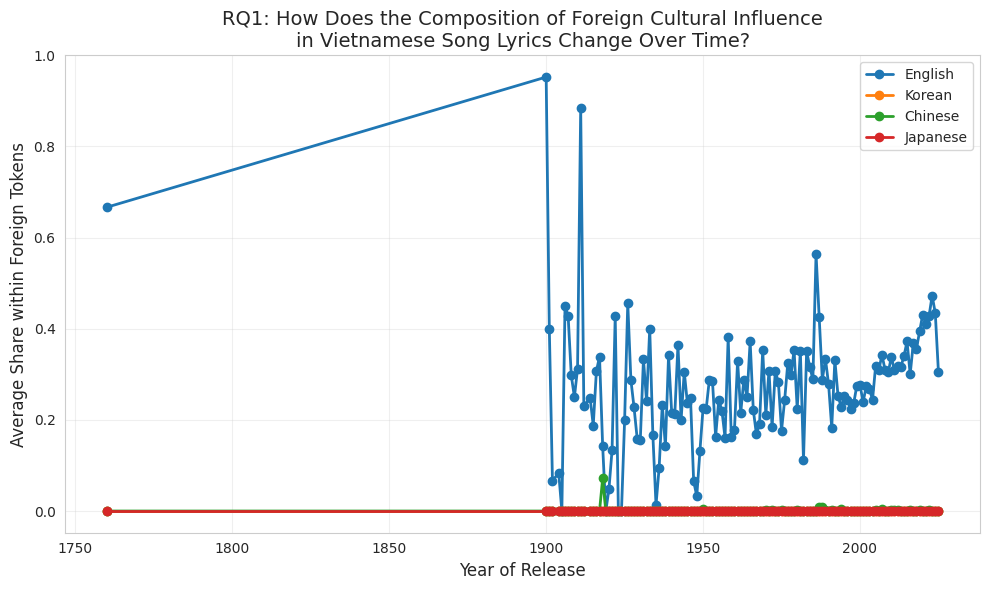

In [34]:
trend_foreign_ratio = (
    df_foreign
    .groupby("year")[[c + "_ratio" for c in foreign_cols]]
    .mean()
    .reset_index()
)

plt.figure()

plt.plot(trend_foreign_ratio["year"], trend_foreign_ratio["num_english_ratio"],
         linewidth=2, marker="o", label="English")
plt.plot(trend_foreign_ratio["year"], trend_foreign_ratio["num_foreign_korean_ratio"],
         linewidth=2, marker="o", label="Korean")
plt.plot(trend_foreign_ratio["year"], trend_foreign_ratio["num_foreign_chinese_ratio"],
         linewidth=2, marker="o", label="Chinese")
plt.plot(trend_foreign_ratio["year"], trend_foreign_ratio["num_foreign_japanese_ratio"],
         linewidth=2, marker="o", label="Japanese")

plt.xlabel("Year of Release")
plt.ylabel("Average Share within Foreign Tokens")
plt.title(
    "RQ1: How Does the Composition of Foreign Cultural Influence\n"
    "in Vietnamese Song Lyrics Change Over Time?"
)
plt.legend()
plt.tight_layout()
plt.show()


Mức độ sử dụng yếu tố ngôn ngữ nước ngoài trong mỗi bài hát Việt thay đổi ra sao theo thời gian?

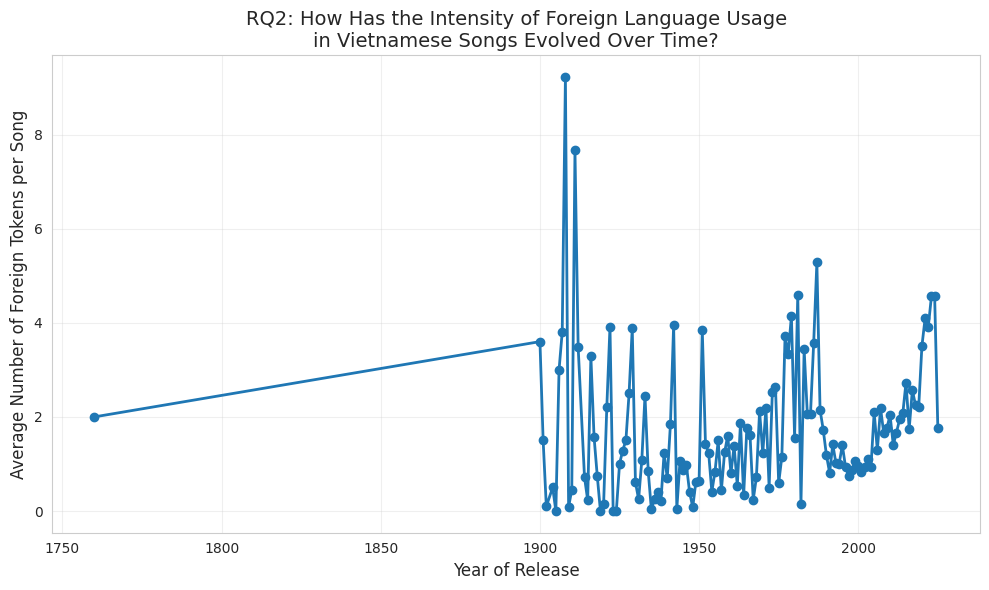

In [35]:
plt.figure()

plt.plot(
    foreign_intensity["year"],
    foreign_intensity["total_foreign"],
    linewidth=2,
    marker="o"
)

plt.xlabel("Year of Release")
plt.ylabel("Average Number of Foreign Tokens per Song")
plt.title(
    "RQ2: How Has the Intensity of Foreign Language Usage\n"
    "in Vietnamese Songs Evolved Over Time?"
)

plt.tight_layout()
plt.show()


Tỷ lệ bài hát Việt có chứa yếu tố ngôn ngữ nước ngoài thay đổi như thế nào theo thời gian?

In [36]:
df["has_foreign"] = df["total_foreign"] > 0

foreign_presence = (
    df.groupby("year")["has_foreign"]
      .mean()
      .reset_index()
)


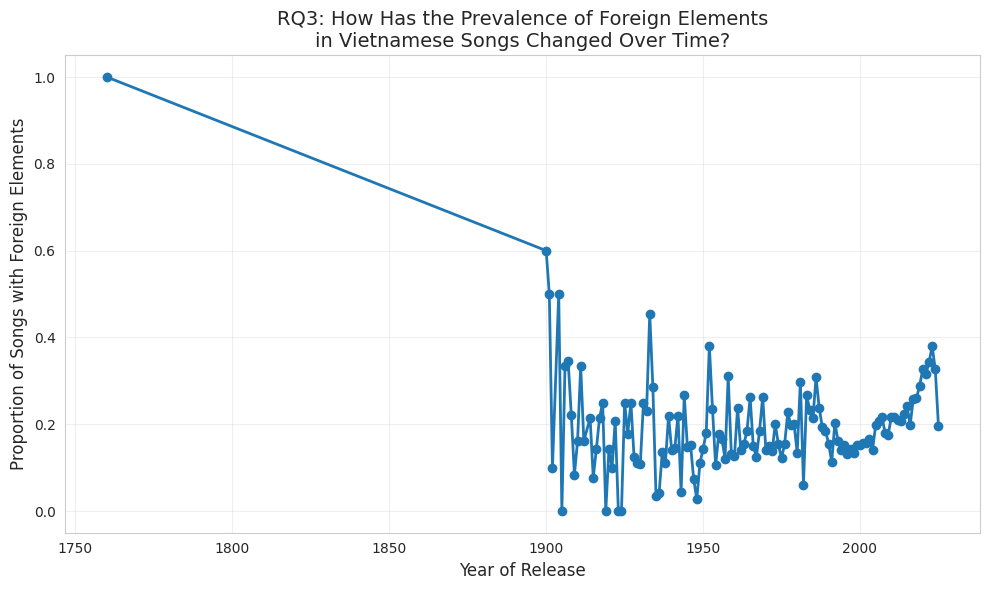

In [37]:
plt.figure()

plt.plot(
    foreign_presence["year"],
    foreign_presence["has_foreign"],
    linewidth=2,
    marker="o"
)

plt.xlabel("Year of Release")
plt.ylabel("Proportion of Songs with Foreign Elements")
plt.title(
    "RQ3: How Has the Prevalence of Foreign Elements\n"
    "in Vietnamese Songs Changed Over Time?"
)

plt.tight_layout()
plt.show()


Ảnh hưởng văn hóa nước ngoài có được thể hiện qua hình thức phiên âm trong lời bài hát hay không?

In [38]:
phien_am_cols = [c for c in df.columns if c.startswith("phien_am_")]

phien_am_presence = (
    df.groupby("year")[phien_am_cols]
      .apply(lambda x: ((x.notnull()) & (x != "")).mean())
      .reset_index()
)


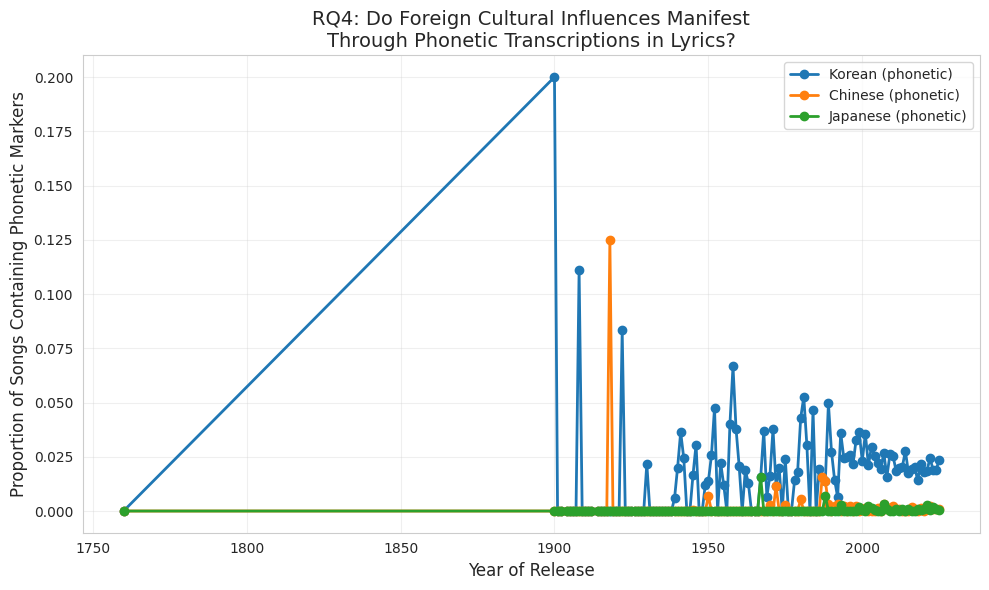

In [39]:
plt.figure()

plt.plot(phien_am_presence["year"],
         phien_am_presence["phien_am_south_korea"],
         linewidth=2, marker="o", label="Korean (phonetic)")

plt.plot(phien_am_presence["year"],
         phien_am_presence["phien_am_chinese"],
         linewidth=2, marker="o", label="Chinese (phonetic)")

plt.plot(phien_am_presence["year"],
         phien_am_presence["phien_am_japan"],
         linewidth=2, marker="o", label="Japanese (phonetic)")

plt.xlabel("Year of Release")
plt.ylabel("Proportion of Songs Containing Phonetic Markers")
plt.title(
    "RQ4: Do Foreign Cultural Influences Manifest\n"
    "Through Phonetic Transcriptions in Lyrics?"
)

plt.legend()
plt.tight_layout()
plt.show()


Việc sử dụng từ Hán Việt trong lời bài hát Việt có xu hướng thay đổi như thế nào theo thời gian?

In [40]:
# Han-Viet trend
hanviet_trend = (
    df.groupby("year")["pct_hanviet"]
      .mean()
      .reset_index()
)

# Tổng kết ảnh hưởng ngoại lai
foreign_mean = (
    df_foreign[foreign_cols]
    .mean()
    .sort_values(ascending=False)
)


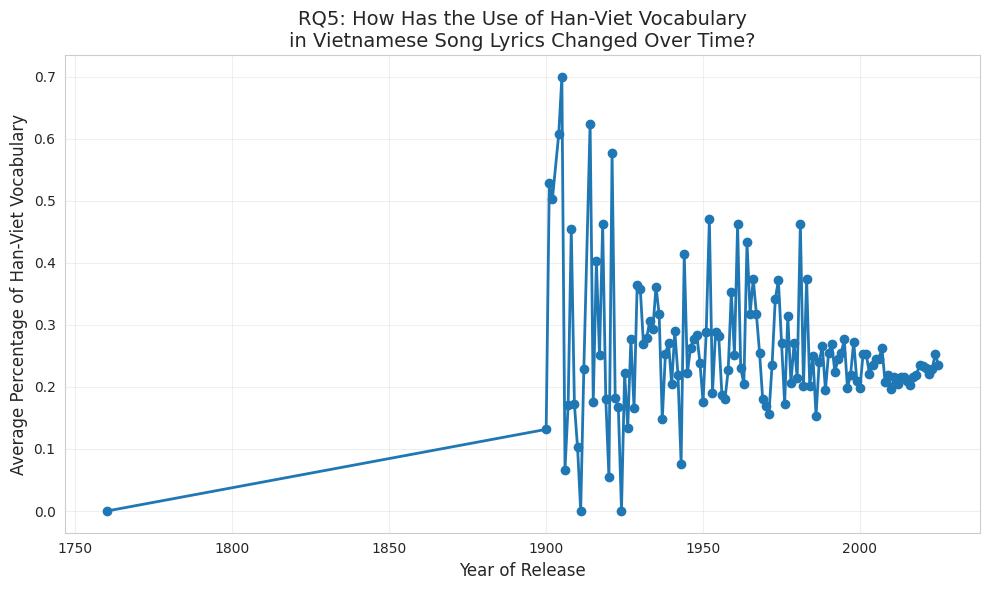

In [41]:
plt.figure()

plt.plot(
    hanviet_trend["year"],
    hanviet_trend["pct_hanviet"],
    linewidth=2,
    marker="o"
)

plt.xlabel("Year of Release")
plt.ylabel("Average Percentage of Han-Viet Vocabulary")
plt.title(
    "RQ5: How Has the Use of Han-Viet Vocabulary\n"
    "in Vietnamese Song Lyrics Changed Over Time?"
)

plt.tight_layout()
plt.show()
